<a href="https://colab.research.google.com/github/pchlenski/misdeed/blob/main/notebooks/MiSDEED_realism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and other preliminaries

In [23]:
# Typical imports

import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

In [24]:
# Misdeed imports

!pip install misdeed==1.0.2
import misdeed
from misdeed.OmicsGenerator import OmicsGenerator
from misdeed.visualization import plot_pca, plot_timecourse
from misdeed.inference import infer_glv_params
print(misdeed.__version__)

1.0.2


In [25]:
# Other imports

from tqdm import tqdm
from functools import partial
from matplotlib.lines import Line2D
from scipy.stats import spearmanr, mannwhitneyu, linregress

# Note: scikit-bio 0.5.7 and onwards have some kind of weird error where 
# they unsuccessfully call scipy.stats. This is worth troubleshooting, but
# for now we just use 0.5.6.
!pip install scikit-bio==0.5.6
from skbio.diversity import alpha_diversity

In [26]:
# Set some global variables

NODE_SIZE = 10
TIME_POINTS = 500
DOWNSAMPLE = 50
N_SAMPLES = 30
NOISE_VAR_LOW = 1e-5
SEED = 10 # For reproducibility
SCALE = 1e-1 # For custom noise distributions

# For case-control
N_PATIENTS = 20
CASE_FRAC = 0.5
INTERVENTION_NODE = 'n0'

# For data realism comparisons, do you want to infer gLV parameters or use random ones?
INFER_PARAMS = True # Set to false to use true-random MiSDEED assumptions

# Custom noise distributions

In this section, we demonstrate how to specify non-standard distributions in MiSDEED. These are useful in case researchers wish to test nonstandard modeling assumptions.*italicized text*

## As part of `gen.generate()`:
The `OmicsGenerator` class's `generate()` method allows users to specify custom distributions. The `functools.partial` function may be necessary to fix some of the distribution parameters. Here we show a basic example: first, we use the typical modeling assumptions (gaussian noise), and then we change to exponential noise instead.

In [27]:
# Initialize generator

np.random.seed(SEED) # For reproducibility

gen = OmicsGenerator(
    node_sizes=NODE_SIZE, 
    time_points=TIME_POINTS, 
    init_full=True
)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:10    0:10
Added x0 vector to node n0
Added growth rates to node n0
Initialized


Text(0.5, 1.0, 'Gaussian noise timecourse')

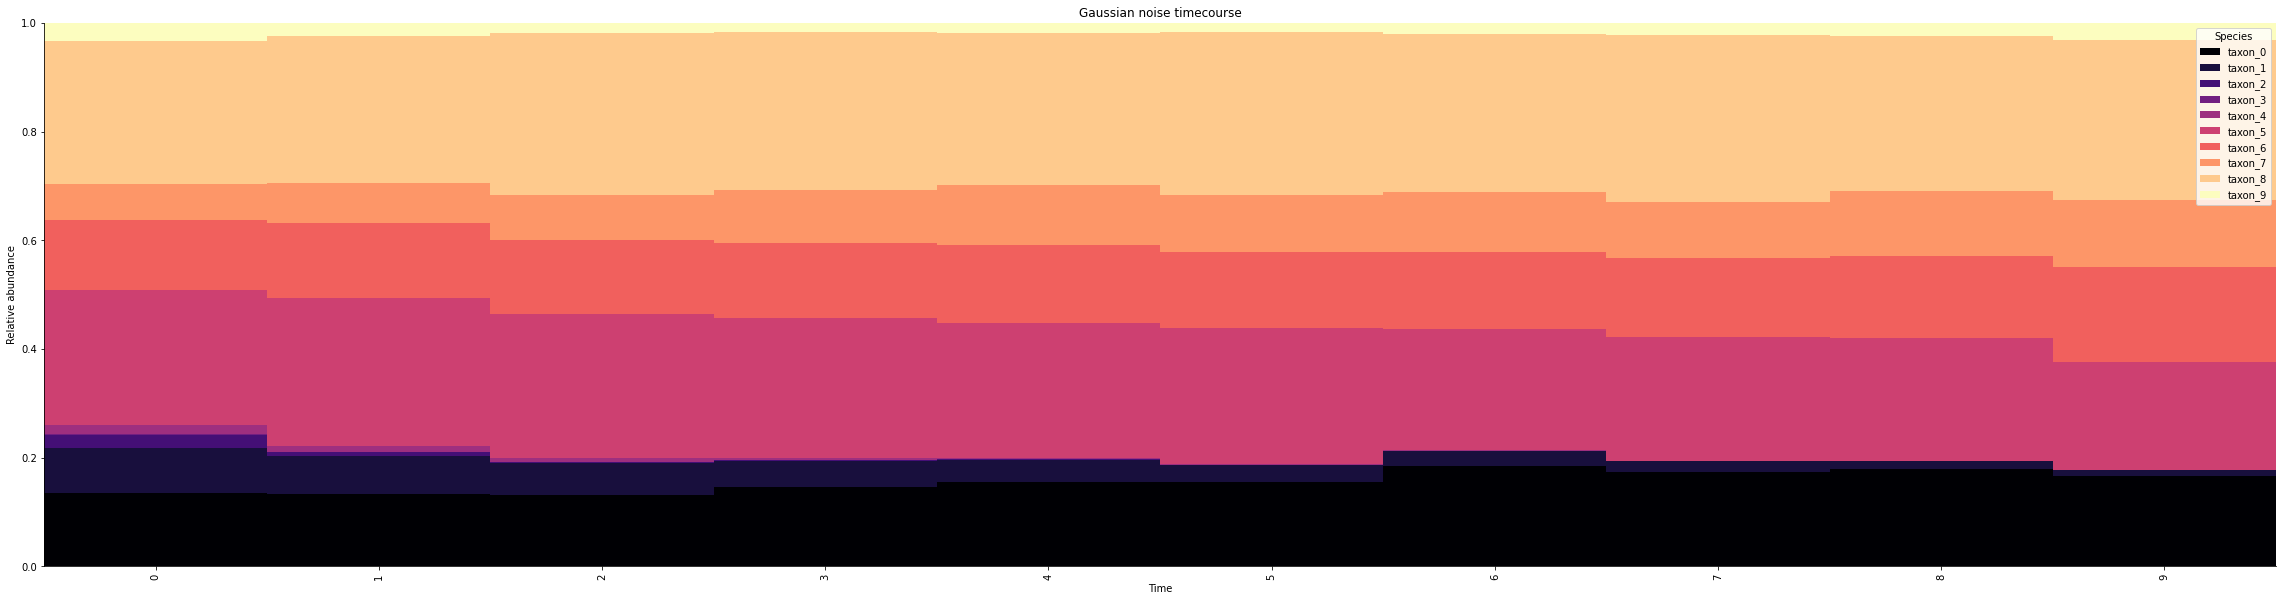

In [28]:
# This is what a typical noise distribution looks like:

np.random.seed(SEED)

_, _, y1 = gen.generate(downsample=DOWNSAMPLE)
plot_timecourse(y1['n0'])

# Make the plots nice
plt.legend(title="Species", labels=[f"taxon_{i}" for i in range(NODE_SIZE)])
plt.xlabel("Time")
plt.ylabel("Relative abundance")
plt.title("Gaussian noise timecourse")

Text(0.5, 1.0, 'Exponential noise timecourse')

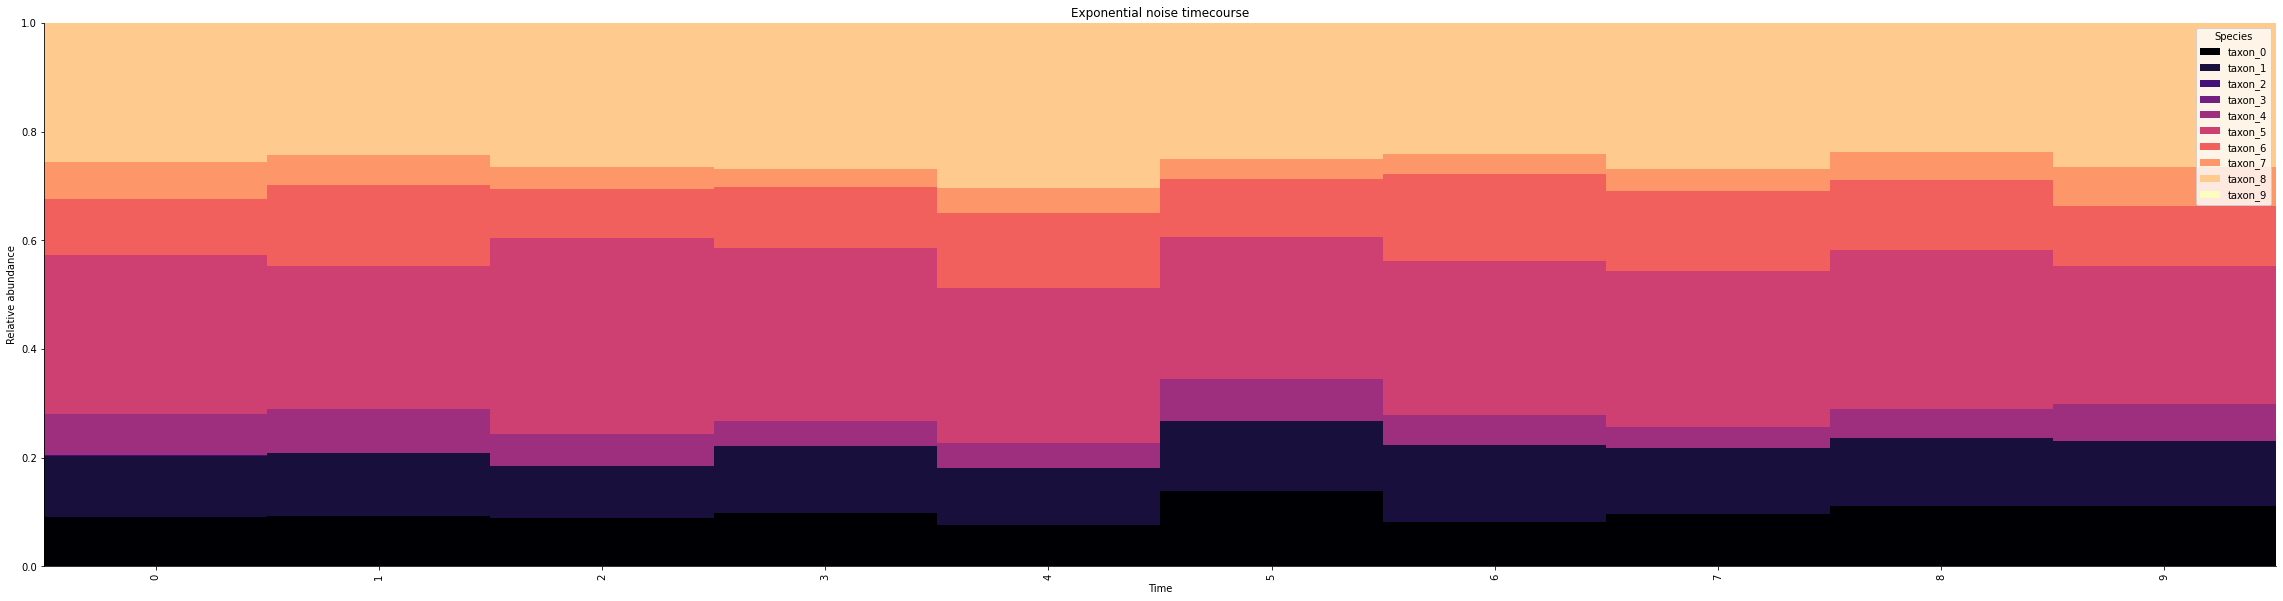

In [29]:
# Using the same generator as before, but with exponentially-distributed noise

np.random.seed(SEED)

our_exponential_dist = partial(np.random.exponential, scale=SCALE) # Note use of partial to set scale
_, _, y2 = gen.generate(downsample=DOWNSAMPLE, noise_distribution=our_exponential_dist)
plot_timecourse(y2['n0'])

# Make the plots nice
plt.legend(title="Species", labels=[f"taxon_{i}" for i in range(NODE_SIZE)])
plt.xlabel("Time")
plt.ylabel("Relative abundance")
plt.title("Exponential noise timecourse")

(array([6.908e+03, 2.133e+03, 6.550e+02, 1.990e+02, 7.000e+01, 2.200e+01,
        7.000e+00, 4.000e+00, 1.000e+00, 1.000e+00]),
 array([2.68744853e-05, 1.14961304e-01, 2.29895733e-01, 3.44830162e-01,
        4.59764592e-01, 5.74699021e-01, 6.89633450e-01, 8.04567880e-01,
        9.19502309e-01, 1.03443674e+00, 1.14937117e+00]),
 <a list of 10 Patch objects>)

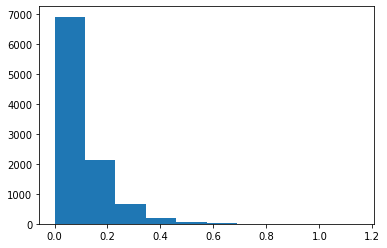

In [30]:
# Verify that our 'dist' function actually is exponentially distributed

np.random.seed(SEED)

plt.hist(our_exponential_dist(size=10000))

(array([2046., 1065.,  805.,  136.,  288.,  452.,  153.,   35.,   16.,
           4.]),
 array([-0.26996118,  3.13508467,  6.54013051,  9.94517636, 13.3502222 ,
        16.75526805, 20.16031389, 23.56535973, 26.97040558, 30.37545142,
        33.78049727]),
 <a list of 10 Patch objects>)

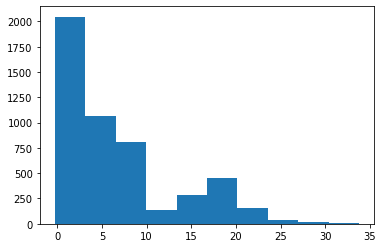

In [31]:
# And verify it works the same in the data.
# Note that we are not downsampling here so that we have a smoother plot to look at

# Noiseless
np.random.seed(SEED)
z1, _, _ = gen.generate(noise_var=0)

# Exponential
np.random.seed(SEED)
z2, _, _ = gen.generate(noise_distribution=our_exponential_dist)

plt.hist((z2['n0'] - z1['n0']).flatten())

## As part of `gen.generate_multiple()`:
When invoked inside of the `OmicsGenerator` class's `generate_multiple()` method, custom distributions specify the distributions for the starting abundances. Here we show PCA plots for regular and exponentially-distributed initial abundances.

100%|██████████| 30/30 [00:09<00:00,  3.02it/s]


Text(0.5, 1.0, '30 timecourses, standard (lognormal) assumptions')

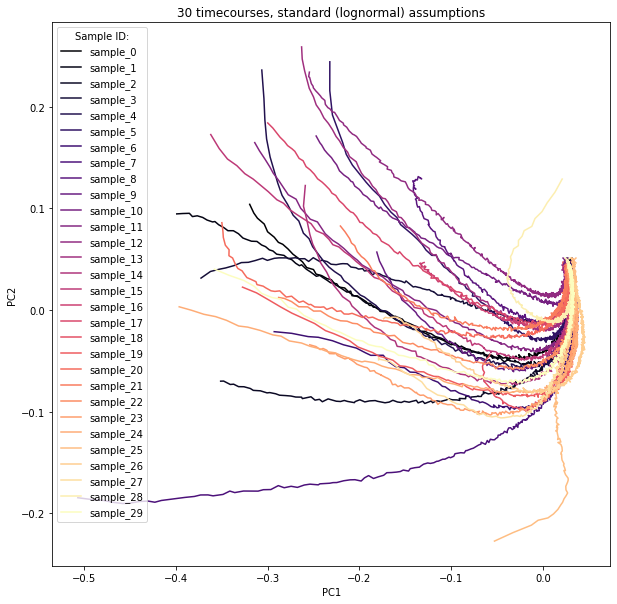

In [32]:
# This is what a typical start distribution looks like

np.random.seed(SEED)
fig = plt.figure(figsize=(10,10))
z3, _, y3 = gen.generate_multiple(
    n=N_SAMPLES, 
    noise_var=NOISE_VAR_LOW
)
plot_pca([y3], 'n0')

# Make the plots nice
plt.legend(title="Sample ID:", labels=[f"sample_{i}" for i in range(N_SAMPLES)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"{N_SAMPLES} timecourses, standard (lognormal) assumptions")

100%|██████████| 30/30 [00:11<00:00,  2.63it/s]


Text(0.5, 1.0, '30 timecourses, exponentially-distributed starts')

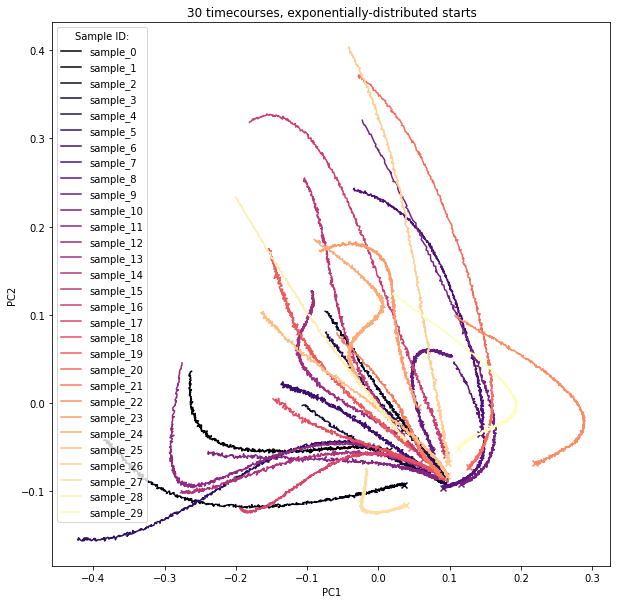

In [33]:
# Here we replace the original distribution with an exponential one

np.random.seed(SEED)
fig = plt.figure(figsize=(10,10))
z4, _, y4 = gen.generate_multiple(
    n=N_SAMPLES,
    noise_var=NOISE_VAR_LOW,
    initial_distribution=our_exponential_dist
)
plot_pca([y4], 'n0')

# Make the plots nice
plt.legend(title="Sample ID:", labels=[f"sample_{i}" for i in range(N_SAMPLES)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"{N_SAMPLES} timecourses, exponentially-distributed starts")

100%|██████████| 30/30 [00:05<00:00,  5.62it/s]


Text(0.5, 1.0, '30 timecourses, uniformly-distributed starts')

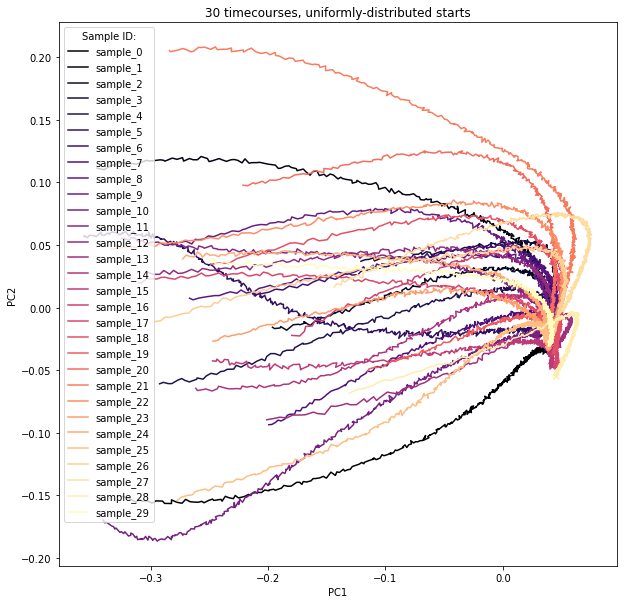

In [34]:
# Here we replace the original distribution with a uniform one

np.random.seed(SEED)
fig = plt.figure(figsize=(10,10))
z5, _, y5 = gen.generate_multiple(
    n=N_SAMPLES,
    noise_var=NOISE_VAR_LOW,
    initial_distribution=np.random.uniform
)
plot_pca([y5], 'n0')

# Make the plots nice
plt.legend(title="Sample ID:", labels=[f"sample_{i}" for i in range(N_SAMPLES)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"{N_SAMPLES} timecourses, uniformly-distributed starts")

Text(0.5, 1.0, '30 timecourses, all assumptions')

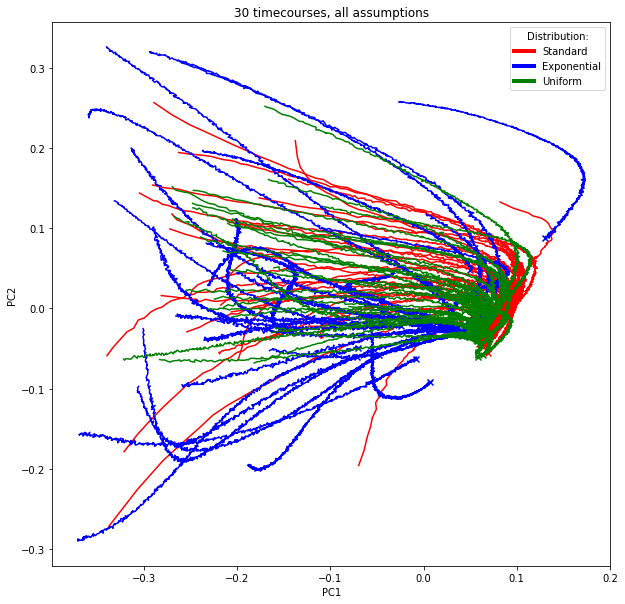

In [35]:
# Superimpose the plots

fig = plt.figure(figsize=(10,10))
plot_pca([y3, y4, y5], "n0", colors=["red", "blue", "green"])

# Make the plots nice
legend_lines = [
    Line2D([0], [0], color="red", lw=4),
    Line2D([0], [0], color="blue", lw=4),
    Line2D([0], [0], color="green", lw=4)
]
plt.legend(handles=legend_lines, title="Distribution:", labels=["Standard", "Exponential", "Uniform"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"{N_SAMPLES} timecourses, all assumptions")

(array([181.,  69.,  18.,  13.,   4.,   4.,   0.,   4.,   4.,   3.]),
 array([ 0.0900222 ,  1.25403873,  2.41805526,  3.58207179,  4.74608832,
         5.91010485,  7.07412138,  8.23813791,  9.40215444, 10.56617096,
        11.73018749]),
 <a list of 10 Patch objects>)

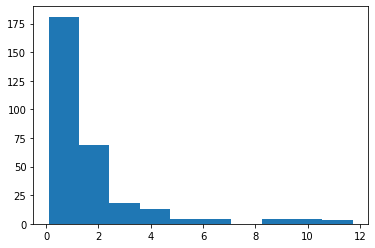

In [36]:
# Distribution of starts under standard (lognormal) assumptions

starts_standard = [z['n0'][0] for z in z3]
starts_standard = np.array(starts_standard).flatten()
plt.hist(starts_standard)

(array([150.,  55.,  38.,  27.,  12.,   4.,   4.,   4.,   3.,   3.]),
 array([1.57869042e-04, 5.55973474e-02, 1.11036826e-01, 1.66476304e-01,
        2.21915782e-01, 2.77355261e-01, 3.32794739e-01, 3.88234218e-01,
        4.43673696e-01, 4.99113174e-01, 5.54552653e-01]),
 <a list of 10 Patch objects>)

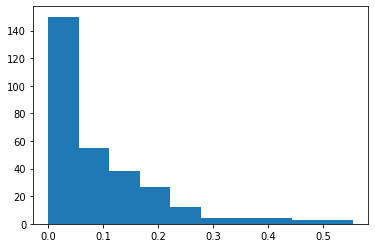

In [37]:
# Distribution of starts under exponential assumptions

starts_exponential = [z['n0'][0] for z in z4]
starts_exponential = np.array(starts_exponential).flatten()
plt.hist(starts_exponential)

(array([32., 42., 24., 30., 30., 21., 26., 34., 38., 23.]),
 array([0.00427329, 0.10366327, 0.20305325, 0.30244323, 0.40183321,
        0.50122318, 0.60061316, 0.70000314, 0.79939312, 0.8987831 ,
        0.99817308]),
 <a list of 10 Patch objects>)

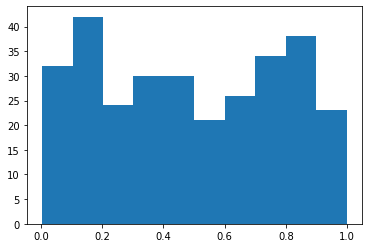

In [38]:
# Distribution of starts under uniform assumptions

starts_uniform = [z['n0'][0] for z in z5]
starts_uniform = np.array(starts_uniform).flatten()
plt.hist(starts_uniform)

## As part of `init_full()`:
When `init_full` is set to `True` for the `OmicGenerator` class initialization, users have the option of setting two additional parameters, `initial_distribution` and `growth_rate_distribution`. Since the initial distribution specification is identical to the one discussed above in the `generate_multiple()` subsection, we will focus only on the growth rates here.

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:10    0:10
Added x0 vector to node n0
Added growth rates to node n0
Initialized


(array([2., 1., 0., 0., 0., 0., 2., 0., 2., 3.]),
 array([-0.9318925 , -0.74375604, -0.55561958, -0.36748312, -0.17934666,
         0.0087898 ,  0.19692626,  0.38506273,  0.57319919,  0.76133565,
         0.94947211]),
 <a list of 10 Patch objects>)

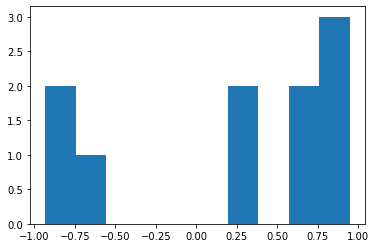

In [39]:
# Normal initialization + plot growth rates

np.random.seed(SEED)

gen_normal_growths = OmicsGenerator(
    node_sizes=NODE_SIZE, 
    time_points=TIME_POINTS, 
    init_full=True
)

plt.hist(gen_normal_growths.get('n0').growth_rates)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:10    0:10
Added x0 vector to node n0
Added growth rates to node n0
Initialized


(array([5., 2., 0., 0., 0., 1., 1., 0., 0., 1.]),
 array([0.00255886, 0.03610112, 0.06964339, 0.10318565, 0.13672792,
        0.17027019, 0.20381245, 0.23735472, 0.27089698, 0.30443925,
        0.33798152]),
 <a list of 10 Patch objects>)

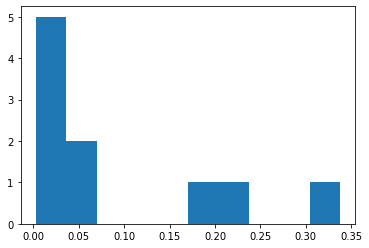

In [40]:
# Exponential growth rates

np.random.seed(SEED)

gen_exp_growths = OmicsGenerator(
    node_sizes=NODE_SIZE, 
    time_points=TIME_POINTS,
    init_full=True,
    growth_rate_distribution=our_exponential_dist
)

plt.hist(gen_exp_growths.get('n0').growth_rates)

## As part of case_control():
When using the `case_control()` method of the `OmicsGenerator` class, users can set the `response_distribution` parameter. This is the random variable that governs how the intervention response is chosen. By default, it is uniform in [-1, 1].

100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Intervention 'CASE' added


100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


Text(0.5, 1.0, '20 timecourses, case-control (regular)')

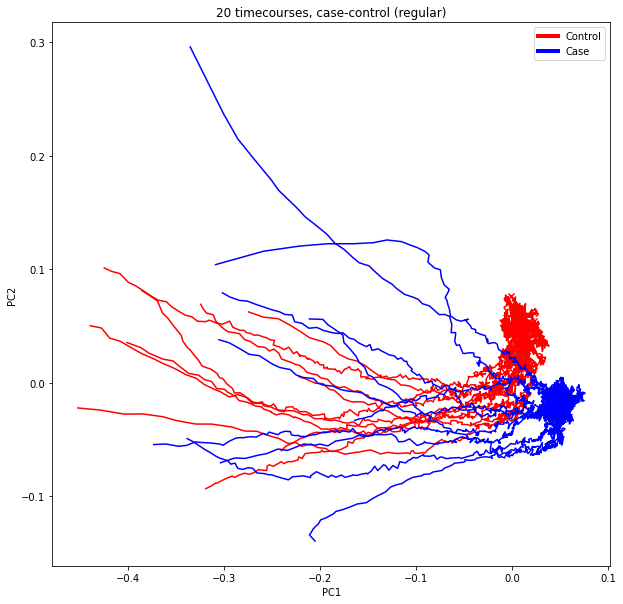

In [41]:
# Regular parameters
np.random.seed(SEED)
_, _, control_y1, _, _, case_y1 = gen.case_control(
    participants=N_PATIENTS,
    case_frac=CASE_FRAC,
    node_name=INTERVENTION_NODE
)

# Pretty figure
fig = plt.figure(figsize=(10,10))
plot_pca([control_y1, case_y1], "n0", colors=["red", "blue"])
legend_lines = [
    Line2D([0], [0], color="red", lw=4),
    Line2D([0], [0], color="blue", lw=4),
]
plt.legend(handles=legend_lines, labels=["Control", "Case"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"{N_PATIENTS} timecourses, case-control (regular)")

100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Intervention 'CASE' added


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Text(0.5, 1.0, '20 timecourses, case-control (exponential)')

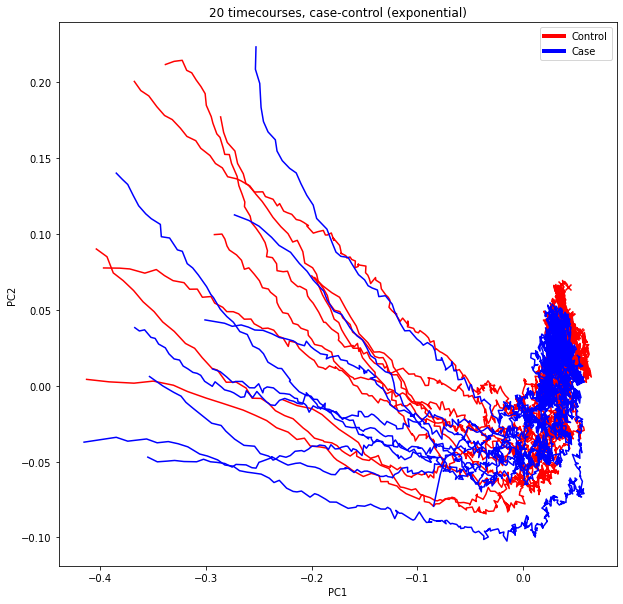

In [42]:
# Exponential response parameters
np.random.seed(SEED)
_, _, control_y2, _, _, case_y2 = gen.case_control(
    participants=N_PATIENTS,
    case_frac=CASE_FRAC,
    node_name=INTERVENTION_NODE,
    response_distribution=our_exponential_dist,
)

# Pretty figure
fig = plt.figure(figsize=(10,10))
plot_pca([control_y2, case_y2], "n0", colors=["red", "blue"])
legend_lines = [
    Line2D([0], [0], color="red", lw=4),
    Line2D([0], [0], color="blue", lw=4),
]
plt.legend(handles=legend_lines, labels=["Control", "Case"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"{N_PATIENTS} timecourses, case-control (exponential)")

# Data realism

## Ground truth data loading and preprocessing

In [43]:
# Get Stein et al dataset from GitHub
stein13 = pd.read_excel(
    io="https://github.com/pchlenski/misdeed/blob/main/src/Stein_et_al_2013_data.xlsx?raw=true",
    sheet_name="Y",
    header=[0,1,3], # Skip ID since it is not useful
    names=None,
    index_col=0,
    skiprows=[4, 16, 17], # Get rid of blank rows, growth vector, clindamycin signal
)
stein13

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Population                                         2                      \
Replicate                                          1                       
time (in d)                                       0         2         3    
undefined_genus_of_Enterobacteriaceae       0.000024  0.869140  0.415010   
Blautia                                     0.000867  0.000040  0.007240   
Barnesiella                                 0.092745  0.000168  0.000129   
undefined_genus_of_unclassified_Mollicutes  0.001445  0.000337  0.000517   
undefined_genus_of_Lachnospiraceae          0.219580  0.000115  0.000088   
Akkermansia                                 0.033082  0.000197  0.051716   
Clostridium_difficile                       0.000000  0.000000  0.000000   
unclassified_Lachnospiraceae                0.032505  0.000075  0.000058   
Coprobacillus                               0.000144  0.000253  0.001810   
Enterococcus                                0.000037  0.002358  0.001034   
Other                                       0.111380  0.004043  0.002586   

Population                                                                \
Replicate                                                                  
time (in d)                                       4         5         6    
undefined_genus_of_Enterobacteriaceae       5.099800  0.429160  0.240180   
Blautia                                     0.004735  2.394700  2.600600   
Barnesiella                                 0.002360  0.000855  0.000688   
undefined_genus_of_unclassified_Mollicutes  0.004545  0.001648  0.001325   
undefined_genus_of_Lachnospiraceae          0.001612  0.000584  0.000470   
Akkermansia                                 0.009470  0.506420  0.311960   
Clostridium_difficile                       0.000000  0.000000  0.000000   
unclassified_Lachnospiraceae                0.001060  0.000384  0.000309   
Coprobacillus                               1.089100  0.001717  0.001037   
Enterococcus                                0.151520  0.017166  0.001380   
Other                                       0.426170  0.090981  0.012423   

Population                                                                \
Replicate                                                                  
time (in d)                                       7         9         12   
undefined_genus_of_Enterobacteriaceae       0.142250  0.469020  0.581790   
Blautia                                     0.118870  0.109960  0.164500   
Barnesiella                                 0.000107  0.000120  0.000188   
undefined_genus_of_unclassified_Mollicutes  0.022957  0.116230  0.224870   
undefined_genus_of_Lachnospiraceae          0.000073  0.000082  0.000128   
Akkermansia                                 0.284510  0.000141  0.000221   
Clostridium_difficile                       0.000000  0.000000  0.000000   
unclassified_Lachnospiraceae                0.000048  0.000054  0.000084   
Coprobacillus                               0.000161  0.000181  0.000283   
Enterococcus                                0.003862  0.000482  0.000096   
Other                                       0.002575  0.010369  0.006037   

Population                                            ...         3            \
Replicate                                             ...         3             
time (in d)                                       16  ...        2         3    
undefined_genus_of_Enterobacteriaceae       0.003252  ...  0.745030  2.958400   
Blautia                                     0.004687  ...  0.000038  0.000117   
Barnesiella                                 0.000007  ...  0.000138  0.000425   
undefined_genus_of_unclassified_Mollicutes  0.019142  ...  0.000060  0.000186   
undefined_genus_of_Lachnospiraceae          0.000005  ...  0.000150  0.000461   
Akkermansia                                 0.000008  ...  0.000158  0.000486   
Clostridium_difficile                       0.000000  ...  0.000171  0.00352

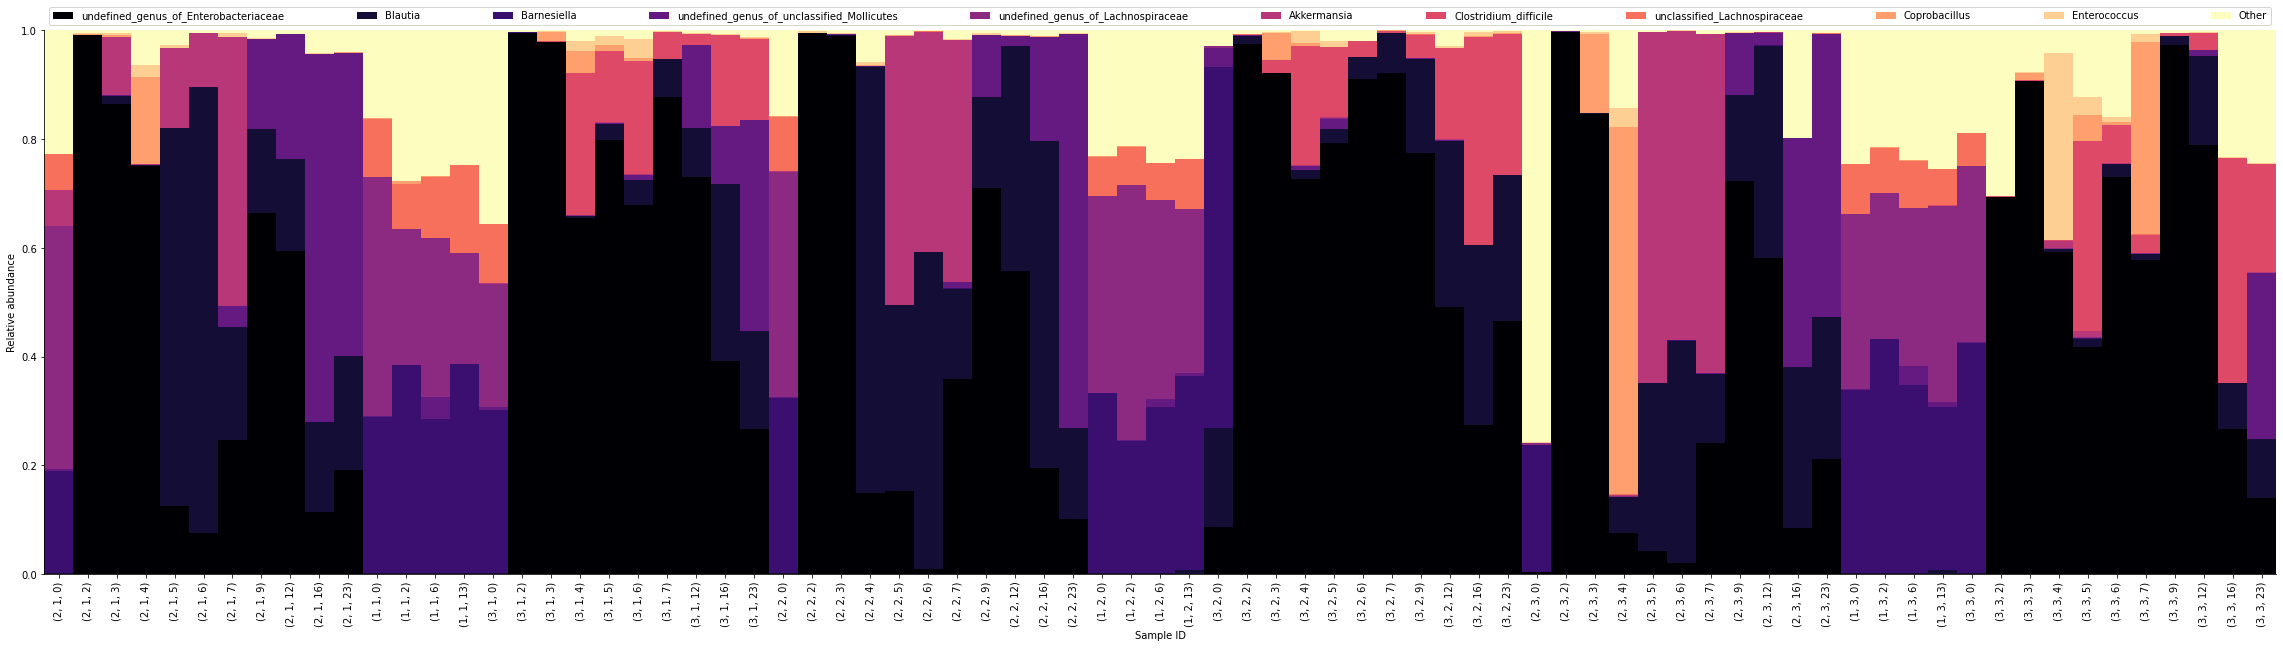

In [44]:
# Plot a relative-abundance timecourse for the Stein (2013) data

# Create relative abundances
stein13_relative = stein13 / stein13.sum()

# Plot data
plot_timecourse(stein13_relative.transpose())

Text(0, 0.5, 'Relative abundance')

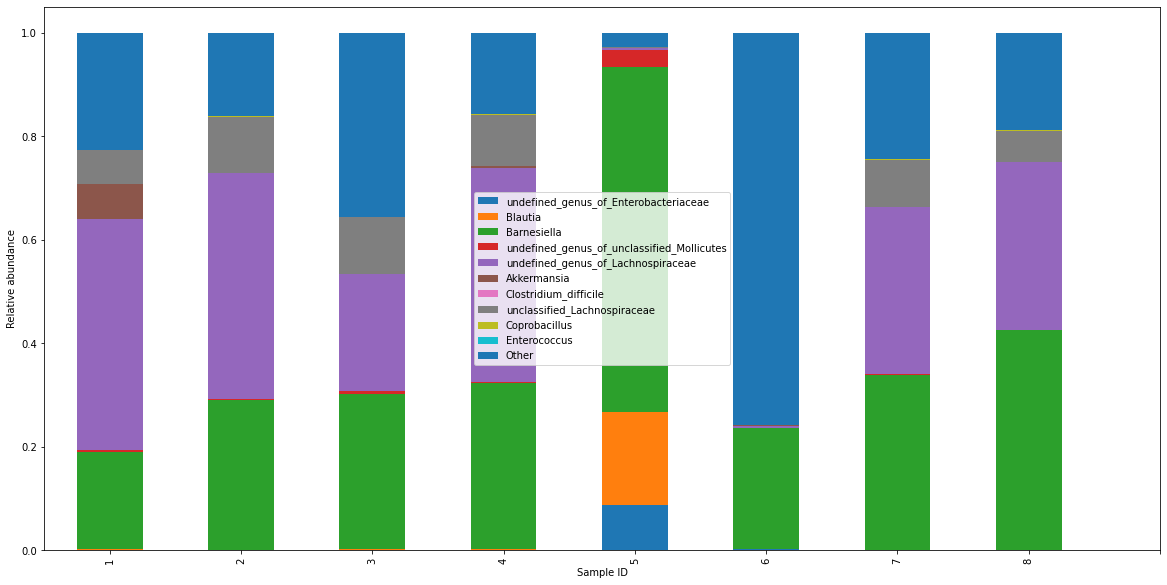

In [45]:
# Visualize distribution of starting states

# Pull out the first time-point for each timecourse.
# Tuples are (population, replicate, time)
# IDs listed correspond to the dropped "ID" column from Stein et al dataset
first_samples = stein13_relative[[
    (2,1,0), # ID=1 
    (1,1,0), # ID=2
    (3,1,0), # ID=3
    (2,2,0), # ID=4
    (3,2,0), # ID=5 
    (2,3,0), # ID=6
    (1,3,0), # ID=7
    (3,3,0)  # ID=8
]]

# Plot the samples
first_samples.transpose().plot(kind="bar", stacked=True, figsize=(20,10))
plt.xticks(range(9), range(1,9))
plt.xlabel("Sample ID")
plt.ylabel("Relative abundance")

## Alpha-diversity

Here we demonstrate various comparisons of alpha-diversity metrics between the Stein (2013) dataset and MiSDEED samples. We show each analysis two ways: with and without inferring gLV parameters from the original dataset. To switch between these analyses, simply set `INFER_PARAMS=False` in the global variable cell (or uncomment below). This allows the reader to assess the effectiveness of the MiSDEED assumptions/models and its inference capabilities separately.

In [46]:
# # Uncomment this cell to see performance without parameter inference
# INFER_PARAMS=False

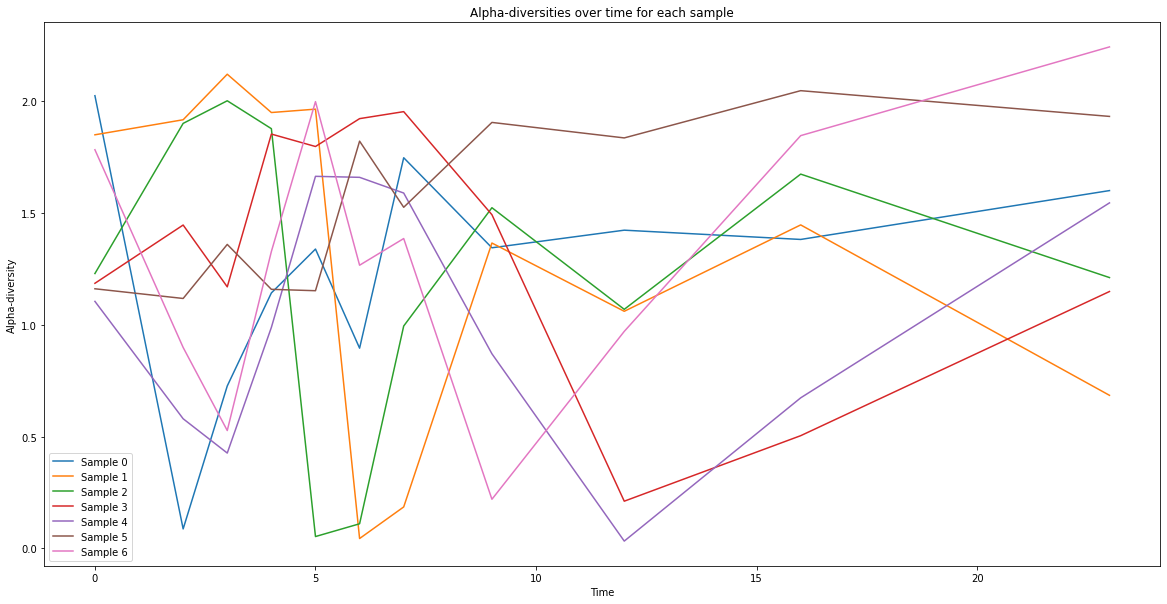

In [47]:
# Plot alpha-diversities
stein13_indices = [0,2,3,4,5,6,7,9,12,16,23] # Omit 13 to make it work out nicely

divs = alpha_diversity(
    metric="shannon", 
    counts=stein13.transpose().values, 
    ids=list(stein13.columns)
)

# Make a nice plot
fig = plt.figure(figsize=(20,10))
for i in range(7):
    plt.plot(stein13_indices, divs.values[i*11 : (i+1)*11], label=f"Sample {i}")
plt.xlabel("Time")
plt.ylabel("Alpha-diversity")
plt.title("Alpha-diversities over time for each sample")
plt.legend()

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:11    0:11
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Added x0 vector to node n0


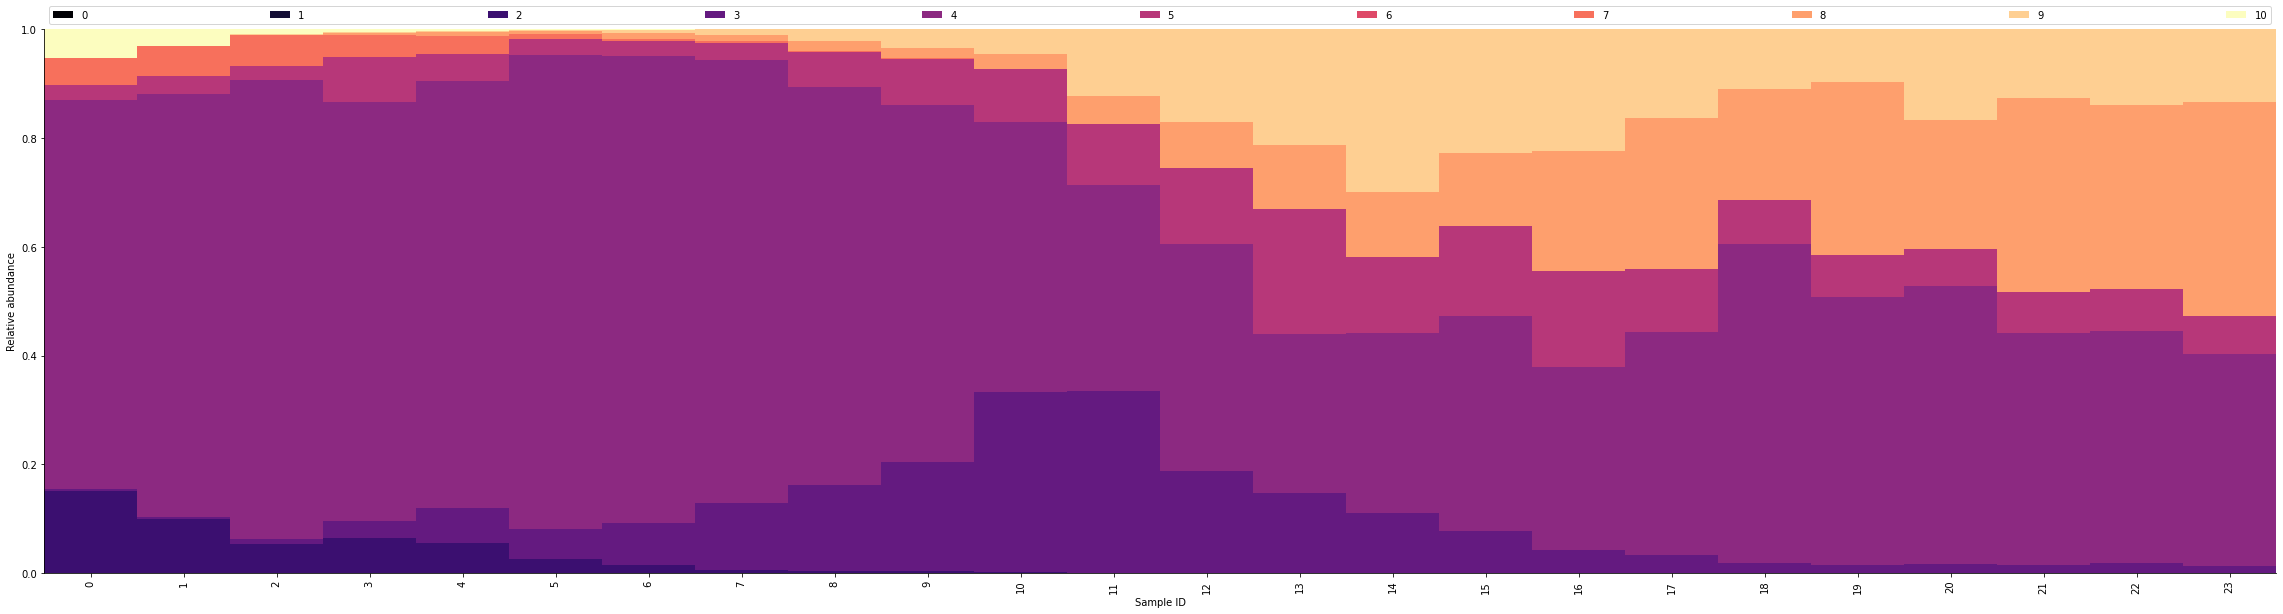

In [48]:
# Generate a timecourse mimicking sample-ID 1:

np.random.seed(SEED)
gen_alpha = OmicsGenerator(
    node_sizes=[11], # Same number of nodes
    init_full=True,
    time_points=240 # Allows us to get 24 days by downsampling
)
gen_alpha.set_initial_value('n0', stein13[(2,1,0)]) # Copy initial value

z,x,y = gen_alpha.generate(dt=.1, downsample=10, noise_var=.1)
plot_timecourse(y['n0'])

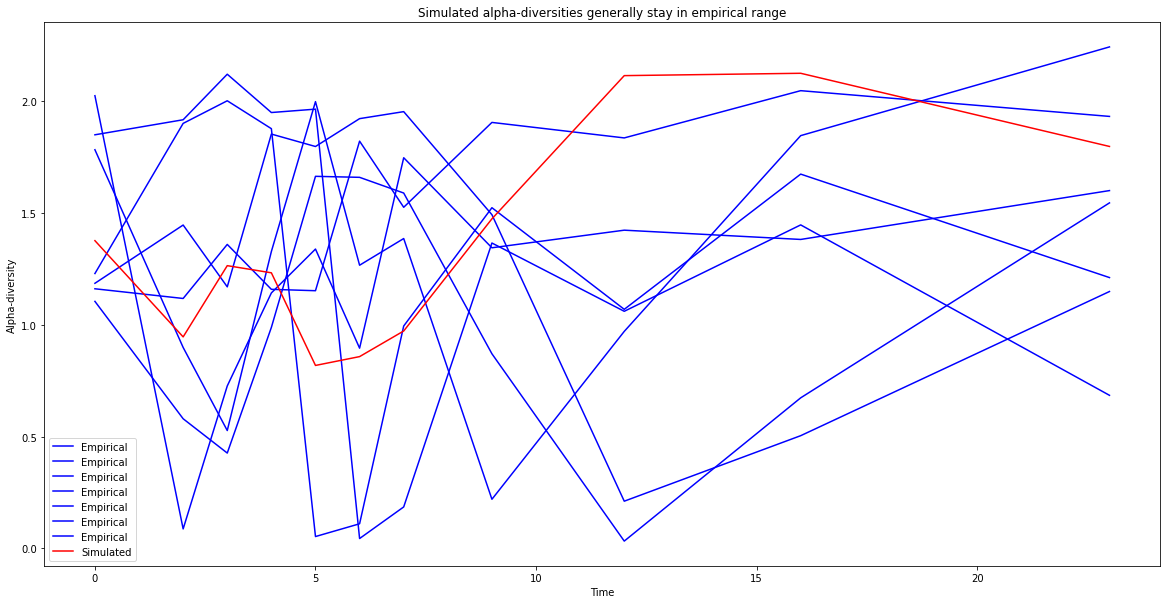

In [49]:
# Plot alpha-diversities of this sample against the previous alpha-diversities.
# Since this is a totally random sample, we just want to visually verify that
# they are within the acceptable range here.

y_matched = y['n0'][stein13_indices]
divs_simulated = alpha_diversity(metric="shannon", counts=y_matched, ids=stein13_indices)

# Plot together 
fig = plt.figure(figsize=(20,10))
for i in range(7):
    plt.plot(stein13_indices, divs.values[i*11 : (i+1)*11], c="blue", label="Empirical")
plt.plot(stein13_indices, divs_simulated, c="red", label="Simulated")
plt.xlabel("Time")
plt.ylabel("Alpha-diversity")
plt.title("Simulated alpha-diversities generally stay in empirical range")
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/usr/local/lib/python3.7/dist-packages/misdeed/OmicsGenerator.py:802: RuntimeWarning: overflow encountered in multiply
  return xt * (growth_rates + interaction_coef + intervention_coef)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ivp/common.py:111: RuntimeWarning: invalid value encountered in multiply
  y1 = y0 + h0 * direction * f0
/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ivp/common.py:113: RuntimeWarning: invalid value encountered in subtract
  d2

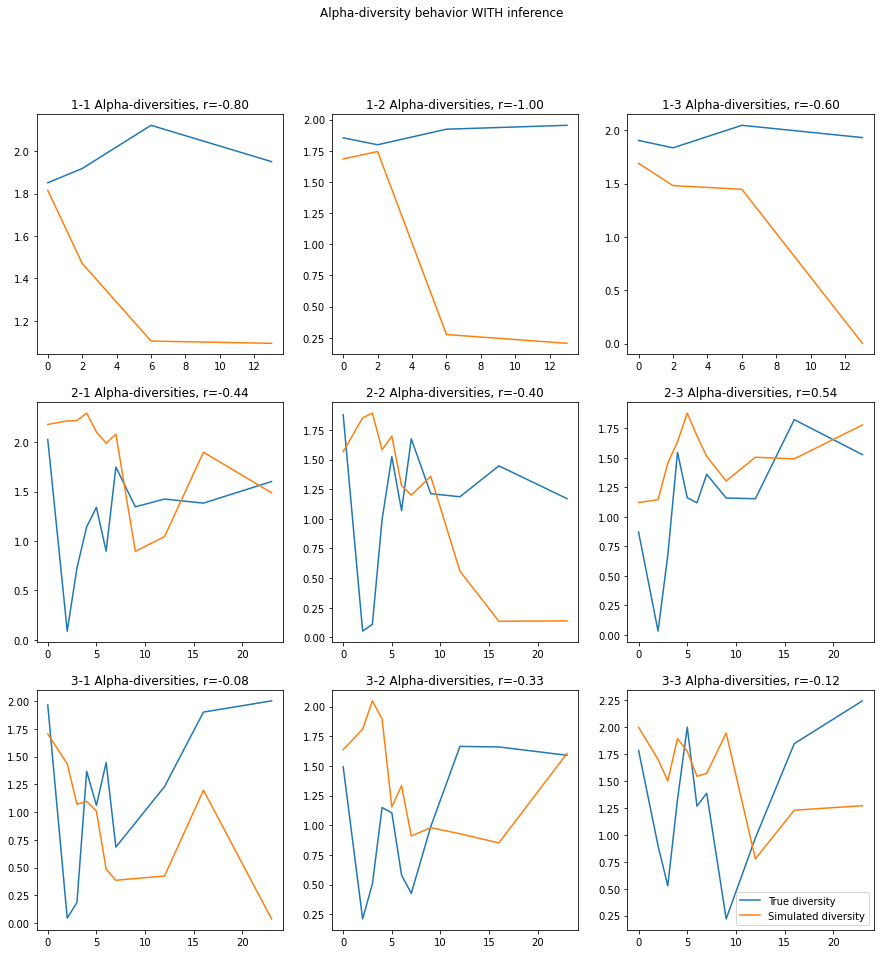

In [50]:
# This experiment tracks how alpha-diversities behave WITH/WITHOUT inferring gLV parameters

# Set seed
np.random.seed(SEED)

# Get true diversities
alpha_divs_true = alpha_diversity(
    metric="shannon",
    counts=stein13.values.T,
    ids=stein13.columns
)

# Dataframe for tracking
simulation_results = pd.DataFrame(columns={"time", "alpha"})

# Make a big plot
k = 0
fig, axs = plt.subplots(3,3, figsize=(15,15))

for population in [1,2,3]: # Populations 1-3
    for replicate in [1,2,3]: # Replicates 1-3
        
        # Get times
        times = list(stein13[(population, replicate)].columns)
        dt = np.diff(np.array(times))
        x0 = stein13[(population,replicate,0)]

        # Init generator
        gen_alpha = OmicsGenerator(
            node_sizes=[11],
            time_points=240,
            silent=True,
            init_full=not INFER_PARAMS # Only init_full if INFER_PARAMS=False
        )

        # Infer gLV params if allowed
        if INFER_PARAMS:
            abundances = stein13[(population, replicate)].values.T
            M,u,E = infer_glv_params(
                abundances=abundances,
                interventions=None,
                interaction_reg=10,
                growth_reg=10,
                intervention_reg=0,
                dt=dt
            )

            # Simulate trajectories
            gen_alpha.add_interaction(
                name='i1', 
                outbound_node_name='n0', 
                inbound_node_name='n0', 
                matrix=M
            )
            gen_alpha.set_initial_value(
                node_name='n0', 
                values=u, 
                growth_rate=True
            )
            gen_alpha.set_initial_value(
                node_name='n0', 
                values=x0
            )

        # Set first time-point to be the same as the empirical one
        gen_alpha.set_initial_value('n0', x0)
        z,x,y = gen_alpha.generate(
            dt=.1, 
            downsample=10, 
            noise_var=.2
        )

        # Compute diversity + Spearman R
        alpha = alpha_diversity(
            metric="shannon",
            counts=y['n0'][times],
            ids=[(population, replicate, time) for time in times]
        )

        # Find ground-truth alpha value
        # This code is kind of hacky, but it allows us to find the index of the alpha-diversity value we need
        alpha_indices = [list(stein13.columns).index((population, replicate, time)) for time in times]
        alpha_true = alpha_divs_true.iloc[alpha_indices]
        r = spearmanr(alpha_true, alpha)[0]

        # Plot diversities
        i,j = np.divmod(k, 3)
        axs[i,j].plot(times, alpha_true, label="True diversity")
        axs[i,j].plot(times, alpha, label="Simulated diversity")
        axs[i,j].set_title(f"{population}-{replicate} Alpha-diversities, r={r:.2f}")

        # Bookkeeping
        k += 1
        experiment_results = [{"time" : t, "alpha" : a} for t,a in zip(times, alpha)]
        simulation_results = simulation_results.append(experiment_results, ignore_index=True)

if INFER_PARAMS:
    plt.suptitle("Alpha-diversity behavior WITH inference")
else:
    plt.suptitle("Alpha-diversity behavior WITHOUT inference")
plt.legend()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 0.98, '')

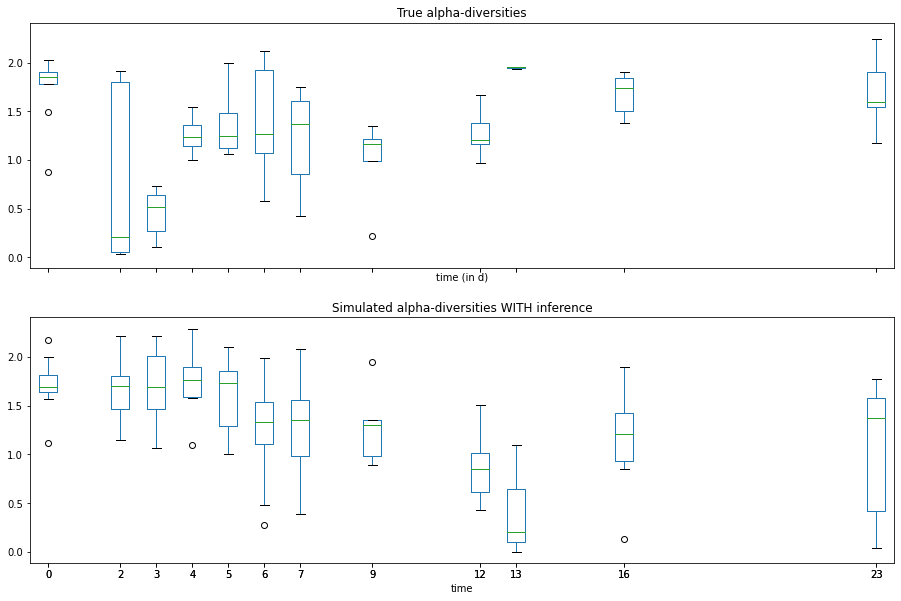

In [51]:
# Maybe a boxplot version of true dists

# Some data massaging
divs_dist = pd.DataFrame(alpha_divs_true, columns=["alpha"])
divs_dist = divs_dist.reset_index()
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=True, sharex=True)
time_ticks = divs_dist["time (in d)"].sort_values().unique()

# True values
divs_dist.boxplot(
    "alpha", 
    by="time (in d)", 
    ax=axs[0],
    positions=time_ticks,
    grid=False,
)
axs[0].set_title("True alpha-diversities")

# Simulated values
simulation_results.boxplot(
    "alpha", 
    by="time", 
    ax=axs[1],
    positions=time_ticks,
    grid=False,
)

if INFER_PARAMS:
    axs[1].set_title("Simulated alpha-diversities WITH inference")
else:
    axs[1].set_title("Simulated alpha-diversities WITHOUT inference")
fig.suptitle("")

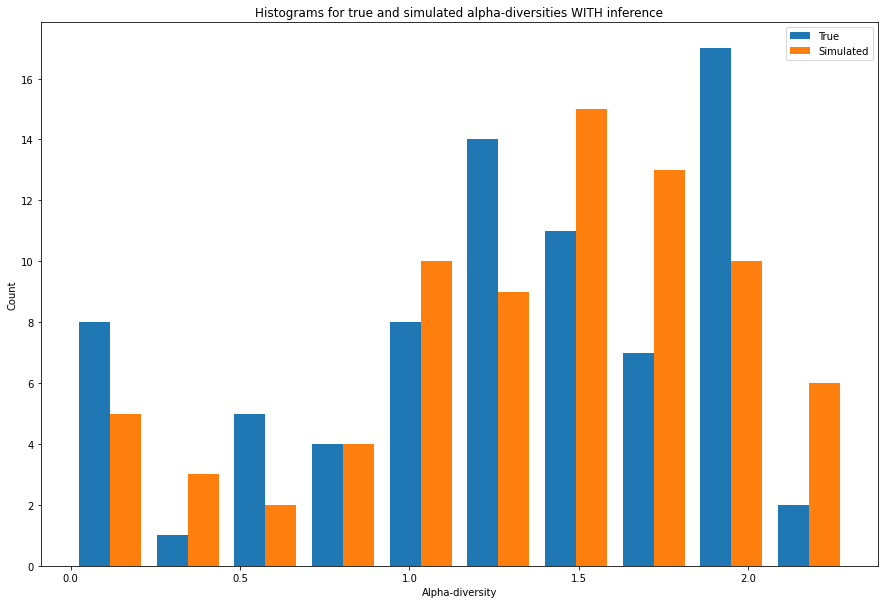

In [52]:
# Plot distributions of real vs. expected alpha-diversities
fig = plt.figure(figsize=(15,10))
plt.hist([divs_dist["alpha"], simulation_results["alpha"]], bins=10)
plt.legend(labels=["True", "Simulated"])
plt.xlabel("Alpha-diversity")
plt.ylabel("Count")

if INFER_PARAMS:
    plt.title("Histograms for true and simulated alpha-diversities WITH inference")
else:
    plt.title("Histograms for true and simulated alpha-diversities WITHOUT inference")

## Sparsity

Here we perform a similar analysis with respect to the sparsity of empirical and real datasets. Once again, we do this with and without parameter inference.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/usr/local/lib/python3.7/dist-packages/misdeed/OmicsGenerator.py:802: RuntimeWarning: overflow encountered in multiply
  return xt * (growth_rates + interaction_coef + intervention_coef)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ivp/common.py:111: RuntimeWarning: invalid value encountered in multiply
  y1 = y0 + h0 * direction * f0
/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ivp/common.py:113: RuntimeWarning: invalid value encountered in subtract
  d2 = norm((f1 - f0) / scale) / h0


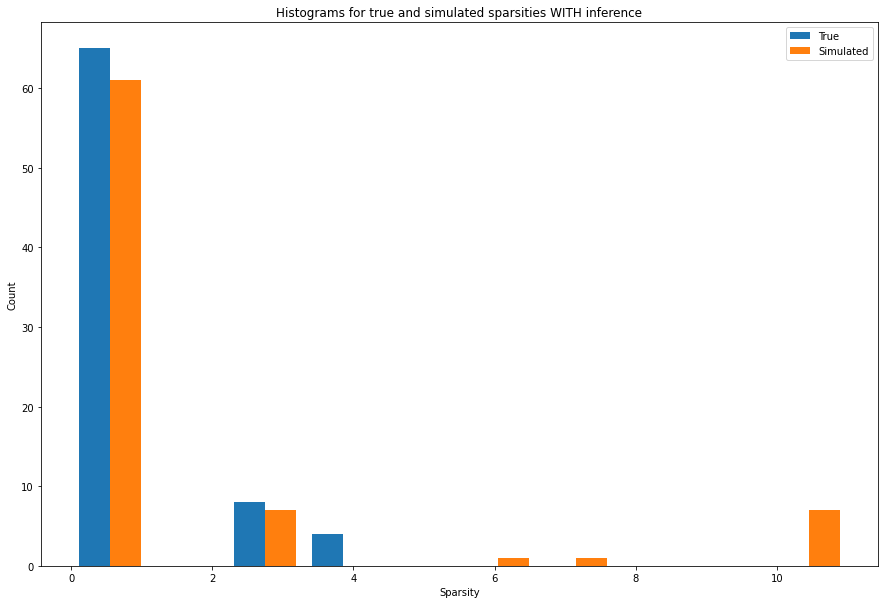

In [53]:
# Count the number of zeros in 77 samples, simulated vs. real, without inference:

np.random.seed(SEED)

# Count zeros in the Stein dataset
stein_zeros = (stein13.values == 0).sum(axis=0)

# Generate a timecourse mimicking sample-ID 1:
sim_zeros = pd.Series(index=stein13.columns)
for population in [1,2,3]:
    for replicate in [1,2,3]:

        # Get times from dataframe
        times = list(stein13[(population, replicate)].columns)
        dt = np.diff(np.array(times))

        # Initialize generator
        gen_sparsity = OmicsGenerator(
            node_sizes=[11],
            time_points=240,
            silent=True,
            init_full=not INFER_PARAMS # Only init_full if INFER_PARAMS=False
        )

        # Infer gLV params
        if INFER_PARAMS:
            abundances = stein13[(population, replicate)].values.T
            M,u,E = infer_glv_params(
                abundances=abundances,
                interventions=None,
                interaction_reg=10,
                growth_reg=10,
                intervention_reg=0,
                dt=dt
            )

            # Simulate trajectories
            gen_sparsity.add_interaction(
                name='i1', 
                outbound_node_name='n0', 
                inbound_node_name='n0', 
                matrix=M
            )
            gen_sparsity.set_initial_value(
                node_name='n0', 
                values=u, 
                growth_rate=True
            )
            gen_sparsity.set_initial_value(
                node_name='n0', 
                values=x0
            )

        # Generate and downsample properly
        _,_,y = gen_sparsity.generate(dt=.1, downsample=10, noise_var=.1)
        y = y['n0'][times]
        for i, time in enumerate(times):
            sim_zeros[(population,replicate,time)] = (y == 0)[:,i].sum()

# Plot
fig = plt.figure(figsize=(15,10))
plt.hist([stein_zeros, sim_zeros])
plt.legend(labels=["True", "Simulated"])
plt.xlabel("Sparsity")
plt.ylabel("Count")

if INFER_PARAMS:
    plt.title("Histograms for true and simulated sparsities WITH inference")
else:
    plt.title("Histograms for true and simulated sparsities WITHOUT inference")

## Differential abundance

Here we demonstrate that using `generate_multiple()` can reliably produce individuals that differ according to Wilcoxon test, and that cases and controls can be distinguished as well. For more details on distinguishing cases and controls, consider looking at the Power Analysis notebook.

In [54]:
# Helper function

def mwu_helper(case, control, idx):
    """ This function cleans up the following code by a lot """
    try:
        p = mannwhitneyu(case.iloc[j], control.iloc[j]).pvalue
    except ValueError:
        p = 1.
    return p

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


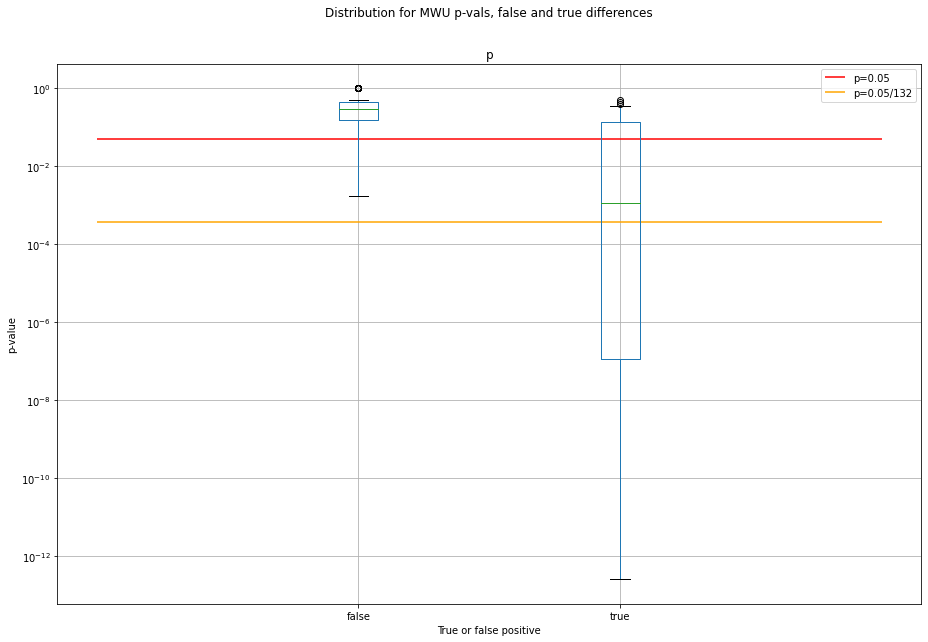

In [55]:
# Differential abundance for the empirical dataset

da_results = pd.DataFrame(columns=["type", "pop_1", "pop_2", "p"])

for population in [1,2,3]:
    # Split into "cases" and "controls"
    case = stein13[(population)]
    other_idx = [1,2,3]
    other_idx.remove(population)
    control = stein13[(other_idx)]

    # Compute statistics for each genus...
    for j in range(len(stein13)):

        p1 = mwu_helper(case, control, j)
        p2 = mwu_helper(case[(1)], case[(2)], j)
        p3 = mwu_helper(case[(1)], case[(3)], j)
        p4 = mwu_helper(case[(2)], case[(3)], j)
        
        # Add to dataframe
        da_results = da_results.append([
            {"type" : "true", "pop_1" : f"{population}", "pop_2" : other_idx, "p" : p1},
            {"type" : "false", "pop_1" : f"{population}.1", "pop_2" : f"{population}.2", "p" : p2},
            {"type" : "false", "pop_1" : f"{population}.1", "pop_2" : f"{population}.3", "p" : p3},
            {"type" : "false", "pop_1" : f"{population}.2", "pop_2" : f"{population}.3", "p" : p4},
        ], ignore_index=True)

# Plot results
da_results.boxplot(by="type", figsize=(15,10))
plt.hlines([0.05], [0], [3], color="red", label="p=0.05")
plt.hlines([0.05/len(da_results)], [0], [3], color="orange", label=f"p=0.05/{len(da_results)}")
plt.yscale("log")
plt.ylabel("p-value")
plt.xlabel("True or false positive")
plt.suptitle("Distribution for MWU p-vals, false and true differences")
plt.legend()

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:11    0:11
Added x0 vector to node n0
Added growth rates to node n0
Initialized


100%|██████████| 3/3 [00:00<00:00, 12.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:11    0:11
Added x0 vector to node n0
Added growth rates to node n0
Initialized


100%|██████████| 3/3 [00:00<00:00, 13.13it/s]


Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:11    0:11
Added x0 vector to node n0
Added growth rates to node n0
Initialized


100%|██████████| 3/3 [00:00<00:00, 12.79it/s]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


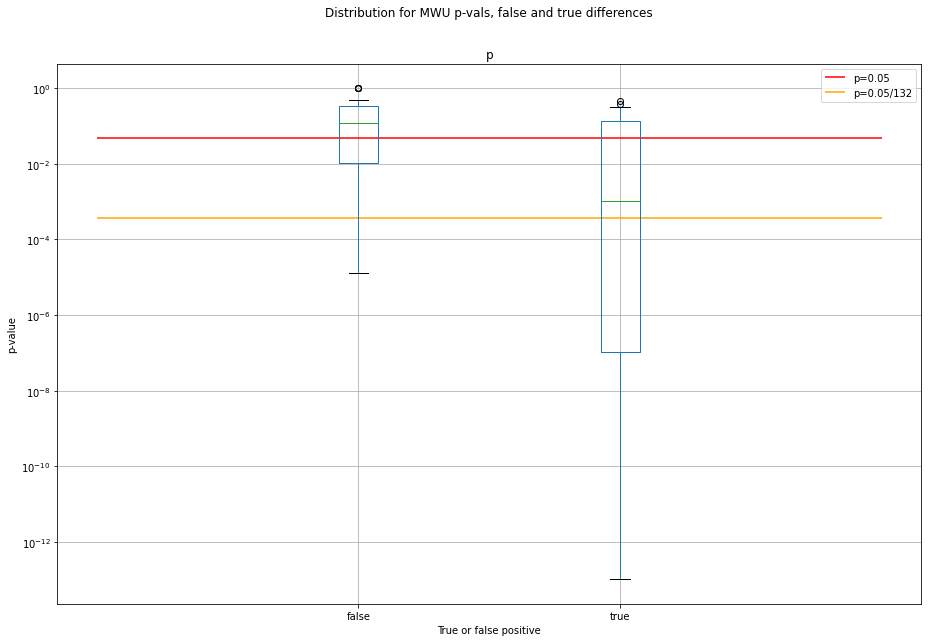

In [56]:
# Differential abundance for MiSDEED synthetic dataset

np.random.seed(SEED)

# Make synthetic dataset
gen_da_data = pd.DataFrame(columns=stein13.columns, index=stein13.index)

# Initialize 3 population generators
for population in [1,2,3]:
    gen = OmicsGenerator([11], time_points=240, init_full=True)

    # Make 3 replicates
    _,_,ys = gen.generate_multiple(n=3, dt=.1, downsample=10, noise_var=0.2)
    for replicate in [1,2,3]:
        times = list(gen_da_data[(population,replicate)].columns)
        vals = ys[replicate-1]['n0'] # get relevant datapoints
        for time in times:
            gen_da_data[(population,replicate,time)] = vals[time]
gen_da_results = pd.DataFrame(columns=["type", "pop_1", "pop_2", "p"])

for population in [1,2,3]:
    # Split into "cases" and "controls"
    case = gen_da_data[(population)]
    other_idx = [1,2,3]
    other_idx.remove(population)
    control = gen_da_data[(other_idx)]

    # Compute statistics for each genus...
    for j in range(len(gen_da_data)):

        # ...across populations:
        try:
            p1 = mannwhitneyu(case.iloc[j], control.iloc[j]).pvalue
        except ValueError:
            p1 = 1.
        
        # within populations, across replicates:
        try:
            p2 = mannwhitneyu(case[(1)].iloc[j], case[(2)].iloc[j]).pvalue
        except ValueError:
            p2 = 1.
        
        try:
            p3 = mannwhitneyu(case[(1)].iloc[j], case[(3)].iloc[j]).pvalue
        except ValueError:
            p3 = 1.
        
        try:
            p4 = mannwhitneyu(case[(2)].iloc[j], case[(3)].iloc[j]).pvalue
        except ValueError:
            p4 = 1.
        
        # Add to dataframe
        gen_da_results = gen_da_results.append([
            {"type" : "true", "pop_1" : f"{population}", "pop_2" : other_idx, "p" : p1},
            {"type" : "false", "pop_1" : f"{population}.1", "pop_2" : f"{population}.2", "p" : p2},
            {"type" : "false", "pop_1" : f"{population}.1", "pop_2" : f"{population}.3", "p" : p3},
            {"type" : "false", "pop_1" : f"{population}.2", "pop_2" : f"{population}.3", "p" : p4},
        ], ignore_index=True)

# Plot results
gen_da_results.boxplot(by="type", figsize=(15,10))
plt.hlines([0.05], [0], [3], color="red", label="p=0.05")
plt.hlines([0.05/len(gen_da_results)], [0], [3], color="orange", label=f"p=0.05/{len(gen_da_results)}")
plt.yscale("log")
plt.ylabel("p-value")
plt.xlabel("True or false positive")
plt.suptitle("Distribution for MWU p-vals, false and true differences")
plt.legend()

Note that the p-values for the false positives here are probably an overestimation, as all initial timepoints are drawn randomly from a lognormal distribution, and thus the first timepoints of each replicate are bound to be quite different from one another. A more generous set of modeling assumptions would set the `discard_first` parameter to something nonzero so that the system has some time to converge away from the unstable starting points.

# MiSDEED self-accuracy

Since many of the preceding experiments rely on matching simulated and empirical datasets, for completeness we would now like to characterize the drift we expect to see between MiSDEED simulated data with random parameters, and simulations from parameters inferred from this dataset. We hope that this helps users distinguish between error arising from parameter estimation and error arising from inappropriate model assumptions.

100%|██████████| 9/9 [00:02<00:00,  3.36it/s]


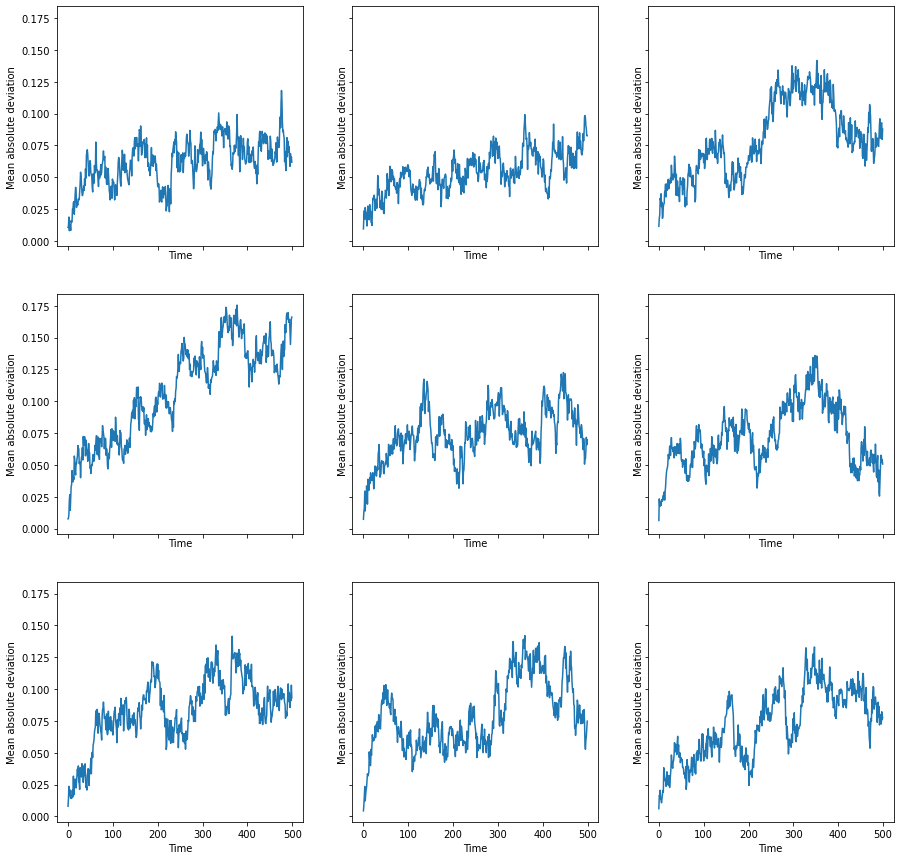

In [57]:
np.random.seed(SEED)

# Set up axes for plotting
fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,15))

for i in tqdm(range(9)):
    # Generate initial values
    gen = OmicsGenerator(
        node_sizes=NODE_SIZE, 
        time_points=TIME_POINTS, 
        init_full=True,
        silent=True
    )
    _,_,y = gen.generate()

    # Infer gLV params from initial values
    M,u,E = infer_glv_params(
        abundances=y['n0'],
        interventions=None,
        interaction_reg=10,
        growth_reg=0,
        intervention_reg=0
    )
    gen2 = OmicsGenerator(
        node_sizes=NODE_SIZE,
        time_points=TIME_POINTS,
        silent=True
    )
    gen2.add_interaction(
        outbound_node_name="n0",
        inbound_node_name="n0",
        matrix=M
    )
    gen2.set_initial_value(
        node_name="n0",
        values=y['n0'][0]
    )
    gen2.set_initial_value(
        node_name="n0",
        values=u,
        growth_rate=True
    )

    # Generate new inferred values
    _,_,y_inferred = gen.generate()

    # Plot mean absolute deviation
    k,j = np.divmod(i,3)
    axs[k,j].plot(np.abs(y['n0'] - y_inferred['n0']).sum(axis=1))
    axs[k,j].set_xlabel("Time")
    axs[k,j].set_ylabel("Mean absolute deviation")
    